## General information

Author: Michiel Plooij

Starting date: 2021/01/20

Disclaimers:
- I'm not a virologist. I am however good in math and simulations
- I'm not a python expert. Python experts might notice a heavy MATLAB accent
- I did not aim for pretty code, just code that works and is readable

Let's start with some general assumptions:

In [1]:
SerialInterval = 4
CurrentFractionBritish = 0.1
BritishMultiplier = 1.3

## Imports and constants
Here we import the packages we need and defining some constants:

In [2]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image, HTML, display

DaysPerWeek = 7
DutchPopulation = 17500000

## Model 1: The simplest model
We will simply start with the initial conditions and propagate the numbers.

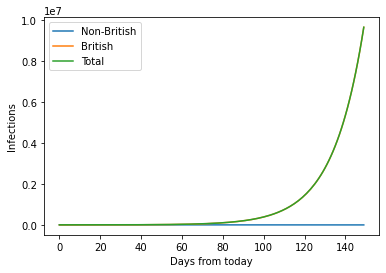

In [3]:
def ExponentialSimulation(InitialCases, R, SerialInterval, numberOfDays):
    days = range(numberOfDays)
    Cases = [0]*numberOfDays
    Cases[0] = InitialCases

    for day in days[1:]:
        Cases[day] = Cases[day-1] * R ** (1 / SerialInterval)
    return days, Cases
    
numberOfDays = 150
Rt_notBritish = 0.95
Rt_British = 1.3

days, Cases_not_British = ExponentialSimulation(5500*(1 - CurrentFractionBritish), Rt_notBritish, SerialInterval, numberOfDays)
days, Cases_British = ExponentialSimulation(5500*CurrentFractionBritish, Rt_British, SerialInterval, numberOfDays)

Cases_Total =[a + b for a, b in zip(Cases_not_British, Cases_British)]

plt.plot(days, Cases_not_British)
plt.plot(days, Cases_British)
plt.plot(days, Cases_Total)
plt.xlabel('Days from today')
plt.ylabel('Infections')
plt.legend(('Non-British', 'British', 'Total'))

# Save for final graph
days1 = days
CasesTotal1 = Cases_Total.copy()
PercentageBritish1 = [100 * b / (a + b) for a, b in zip(Cases_not_British, Cases_British)]

## Calculating the current reproduction rate

Ok, so far the future seems quite dramatic. But there is hope:
- The above model does not take into account that there is a vaccine
- The above model does not take into account that people who were infected are now immune
- The values for the reproduction number seem to be incorrect

Let's have a look at a model that does take this into account and let's start with loading some data and analyzing it. This will give us some numbers we will use later. 
Let's load some data of the RIVM and process it

In [4]:
CountyData = pd.read_csv('COVID-19_aantallen_gemeente_per_dag.csv', delimiter = ';')
AllCaseData = pd.read_csv('COVID-19_casus_landelijk.csv', delimiter = ';')

# Sum the positive tests, hospitalizations and deceased per date
dates = CountyData.Date_of_publication
dates = dates.drop_duplicates()

Total_reported = [0]*len(dates)
Total_hospitalized = [0]*len(dates)
Total_deceased = [0]*len(dates)

for idx, date in enumerate(dates):
    data_date = CountyData.loc[CountyData['Date_of_publication'] == date]
    Total_reported[idx] = data_date.Total_reported.sum()
    Total_hospitalized[idx] = data_date.Hospital_admission.sum()
    Total_deceased[idx] = data_date.Deceased.sum()

dates = dates.to_list()

AllCaseDataNovember = AllCaseData.loc[AllCaseData.Date_statistics.str.startswith('2020-11')]
AllCaseDataNovemberHospitalized = AllCaseDataNovember.loc[AllCaseDataNovember.Hospital_admission == 'Yes']
HospitalizationsPerCaseNovember = len(AllCaseDataNovemberHospitalized) / len(AllCaseDataNovember)

Now we want to know that the current reproduction number is. There are many ways to find this number. Since there is a clear weekly trend in the number of infections, I chose to compare the numbers of one day with the same numbers a week earlier. I ignore the fact that most cases are not reported on the day of the infection or hospitalization. I don't believe this has a significant impact on the result below.

So what I do is:

$R = (\frac{C_n}{C_{n-7}}) ^ \frac{d}{7}$

where $d$ is the serial interval, $C$ is the number of cases (either positive tests or hospitalizations) and 7 is the number of days per week.

In [5]:
# Calculate Rt
R_reports = [0]*(len(dates)-DaysPerWeek)
R_hospitalized = [0]*(len(dates)-DaysPerWeek)

for idx in range(len(R_reports)):
    R_reports[idx] = (Total_reported[idx+DaysPerWeek] / Total_reported[idx]) ** (SerialInterval / DaysPerWeek)
    R_hospitalized[idx] = (Total_hospitalized[idx+DaysPerWeek] / Total_hospitalized[idx]) ** (SerialInterval / DaysPerWeek)
    # In the summer, there were some really low numbers, which cause problems:
    if np.isinf(R_reports[idx]) or np.isnan(R_reports[idx]):
        R_reports[idx] = 1
    if np.isinf(R_hospitalized[idx]) or np.isnan(R_hospitalized[idx]):
        R_hospitalized[idx] = 1

c:\python\demcon2020\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in longlong_scalars
  
c:\python\demcon2020\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in longlong_scalars
  import sys
c:\python\demcon2020\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys


Now these numbers are quite noisy, so we filter them with a second order Butterworth filter and plot them:

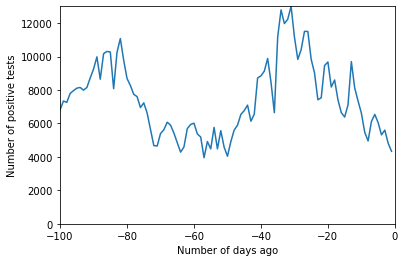

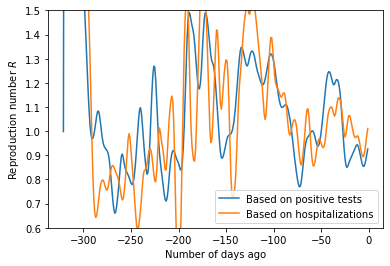

In [6]:
# Filter Rt
FilterTimeConstant = 5
b, a = signal.butter(2, 1 / FilterTimeConstant)
R_reports_filtered = signal.filtfilt(b, a, R_reports)
R_hospitalized_filtered = signal.filtfilt(b, a, R_hospitalized)

NumberOfDaysAgo = range(-len(R_reports_filtered), 0)
plt.plot(NumberOfDaysAgo, Total_reported[7:])
plt.xlim(-100, 0)
plt.ylim(0, 13000)
plt.xlabel('Number of days ago')
plt.ylabel('Number of positive tests')

plt.figure()
plt.plot(NumberOfDaysAgo, R_reports_filtered)
plt.plot(NumberOfDaysAgo, R_hospitalized_filtered)

plt.ylim(0.6, 1.5)
plt.xlabel('Number of days ago')
plt.ylabel('Reproduction number $R$')
plt.legend(('Based on positive tests', 'Based on hospitalizations'))

Finally, we take the average over the last two weeks to estimate the current reproduction rate:

In [7]:
# Estimate current Rts
Rt_current_reported = np.mean(R_reports[len(R_reports)-14:len(R_reports)])
Rt_current_hospitalized = np.mean(R_hospitalized[len(R_hospitalized)-14:len(R_hospitalized)])

print('R based on positive tests', Rt_current_reported)
print('R based on hospitalizations', Rt_current_hospitalized)

R based on positive tests 0.9011363651195581
R based on hospitalizations 0.9610540141522262


From this data, we can estimate $R$. The numbers below are the total reproduction number. Given the percentage of British mutation cases and the relationship between their reproduction rates, we can calculate the reproduction rate of the non-British variant:

$R_{\texttt{Non-British}} = \frac{R}{\texttt{FractionNonBritish + BritishMultiplier * FractionBritish}}$

In [8]:
Rt_current_NonBritish_reported = Rt_current_reported / (CurrentFractionBritish * BritishMultiplier + 1 - CurrentFractionBritish)
Rt_current_NonBritish_hospitalized = Rt_current_hospitalized / (CurrentFractionBritish * BritishMultiplier + 1 - CurrentFractionBritish)

print('R non-British based on positive tests', Rt_current_NonBritish_reported)
print('R non-British based on hospitalizations', Rt_current_NonBritish_hospitalized)
print(' ')
print('R British based on positive tests', Rt_current_NonBritish_reported * BritishMultiplier)
print('R British based on hospitalizations', Rt_current_NonBritish_hospitalized * BritishMultiplier)

R non-British based on positive tests 0.8748896748733576
R non-British based on hospitalizations 0.9330621496623558
 
R British based on positive tests 1.1373565773353649
R British based on hospitalizations 1.2129807945610627


## Model 2: Simple with vaccines and immunity
Now we want to predict what is going to happen. Let's start with a simple model. But first the assumptions of course:

In [9]:
DailyVaccinated = 150000 / 2 / DaysPerWeek
VaccineEfficacy = 0.95
VaccineWorkingDelay = 21
CaseUnderestimationFraction = 0.7
CasesTotalSanquin = 2300000
VaccinePreventsSpreadingFraction = 0      # 0: does not prevent, 1: prevents all
ThrustFactorReproductionNumber = 0.5      # 0: thrust tests, 1: thrust hospitals
HospitalizationsPerInfection = 0.0235

In [10]:
def Model1(NumberOfDaysPredicted, CasesNonBritish0, CasesBritish0, Immune0, Susceptible0, R_NonBritish):
    DaysFromNow = range(NumberOfDaysPredicted)
    CasesNonBritish = [0]*NumberOfDaysPredicted
    CasesBritish = [0]*NumberOfDaysPredicted
    CasesNonBritish[0] = CasesNonBritish0
    CasesBritish[0] = CasesBritish0
    Immune = Immune0
    SusceptibleForSpreading = DutchPopulation - Immune
    SusceptibleForInfection = DutchPopulation - Immune
    SpreadingBritish = CasesBritish0
    SpreadingNonBritish = CasesNonBritish0
    Vaccinated = 0
    
    for day in range(NumberOfDaysPredicted-1):
        Rt_NonBritish = R_NonBritish * (SusceptibleForSpreading / DutchPopulation)
        SpreadingNonBritish = SpreadingNonBritish * Rt_NonBritish ** (1 / SerialInterval)
        SpreadingBritish = SpreadingBritish * (Rt_NonBritish * BritishMultiplier) ** (1 / SerialInterval)
        
        CasesNonBritish[day + 1] = SpreadingNonBritish * SusceptibleForInfection / SusceptibleForSpreading
        CasesBritish[day + 1] =  SpreadingBritish * SusceptibleForInfection / SusceptibleForSpreading
        Immune = Immune + (SpreadingNonBritish + SpreadingBritish) / CaseUnderestimationFraction
        if day > VaccineWorkingDelay:
            Vaccinated = Vaccinated + DailyVaccinated
        
        SusceptibleForInfection = DutchPopulation - Immune - Vaccinated * VaccineEfficacy
        SusceptibleForSpreading = DutchPopulation - Immune - Vaccinated * VaccineEfficacy * VaccinePreventsSpreadingFraction
    return DaysFromNow, CasesNonBritish, CasesBritish

We can now run the model and review the results:

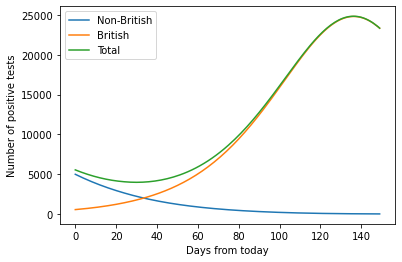

In [11]:
NumberOfDaysPredicted = 150
Immune0 = CasesTotalSanquin
Susceptible0 = DutchPopulation - Immune0
R_current_NonBritish = (ThrustFactorReproductionNumber*Rt_current_NonBritish_hospitalized + (1 - ThrustFactorReproductionNumber)*Rt_current_NonBritish_reported) / (Susceptible0 / DutchPopulation)

CasesNonBritish0 = np.mean(Total_reported[len(Total_reported)-7:]) * (1 - CurrentFractionBritish)
CasesBritish0 = np.mean(Total_reported[len(Total_reported)-7:]) * CurrentFractionBritish

DaysFromNow, CasesNonBritish, CasesBritish = Model1(NumberOfDaysPredicted, 
                                                    CasesNonBritish0, 
                                                    CasesBritish0, 
                                                    Immune0, 
                                                    Susceptible0,
                                                    R_current_NonBritish)

CasesTotal = [a + b for a, b in zip(CasesNonBritish, CasesBritish)]

plt.plot(DaysFromNow, CasesNonBritish)
plt.plot(DaysFromNow, CasesBritish)
plt.plot(DaysFromNow, CasesTotal)
plt.xlabel('Days from today')
plt.ylabel('Number of positive tests')
plt.legend(('Non-British', 'British', 'Total'))

# Save for final graph
days2 = DaysFromNow
CasesTotal2 = CasesTotal.copy()
PercentageBritish2 = [100 * b / (a + b) for a, b in zip(CasesNonBritish, CasesBritish)]

Finally we predict the number of hospitalizations

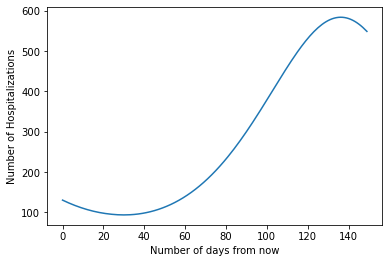

In [12]:
HospitalizationsTotal = [HospitalizationsPerInfection * CasesTotal[dayIdx] for dayIdx in range(NumberOfDaysPredicted)]

plt.plot(DaysFromNow, HospitalizationsTotal)

plt.xlabel('Number of days from now')
plt.ylabel('Number of Hospitalizations')

HospitalizationsTotal2 = HospitalizationsTotal.copy()

## Model 3: Include age groups
The result below is a lot more comforting than the graphs seen earlier. But there is still more hope:
- The vaccines will first mostly be distributed among groups that are vulnerable and therefore contribute more to the number of hospitalizations and deaths.
Therefore, we make it more sophisticated: we are going to look at different age groups. We again first collect data what we will need later.

### Assumption: The positive test distribution is a good approximation for the likelyhood distribution of infections.
### Assumption: Every person is equally likely to infect any other person (no age group boundaries)

### 4.1 Obtaining data
We start with determining the distribution over the age groups, both the group size and the number of cases and hospitalizations. This data is obtained from the CBS and stichting NICE.

Text(0, 0.5, 'Chance to be hospitalized after a positive test')

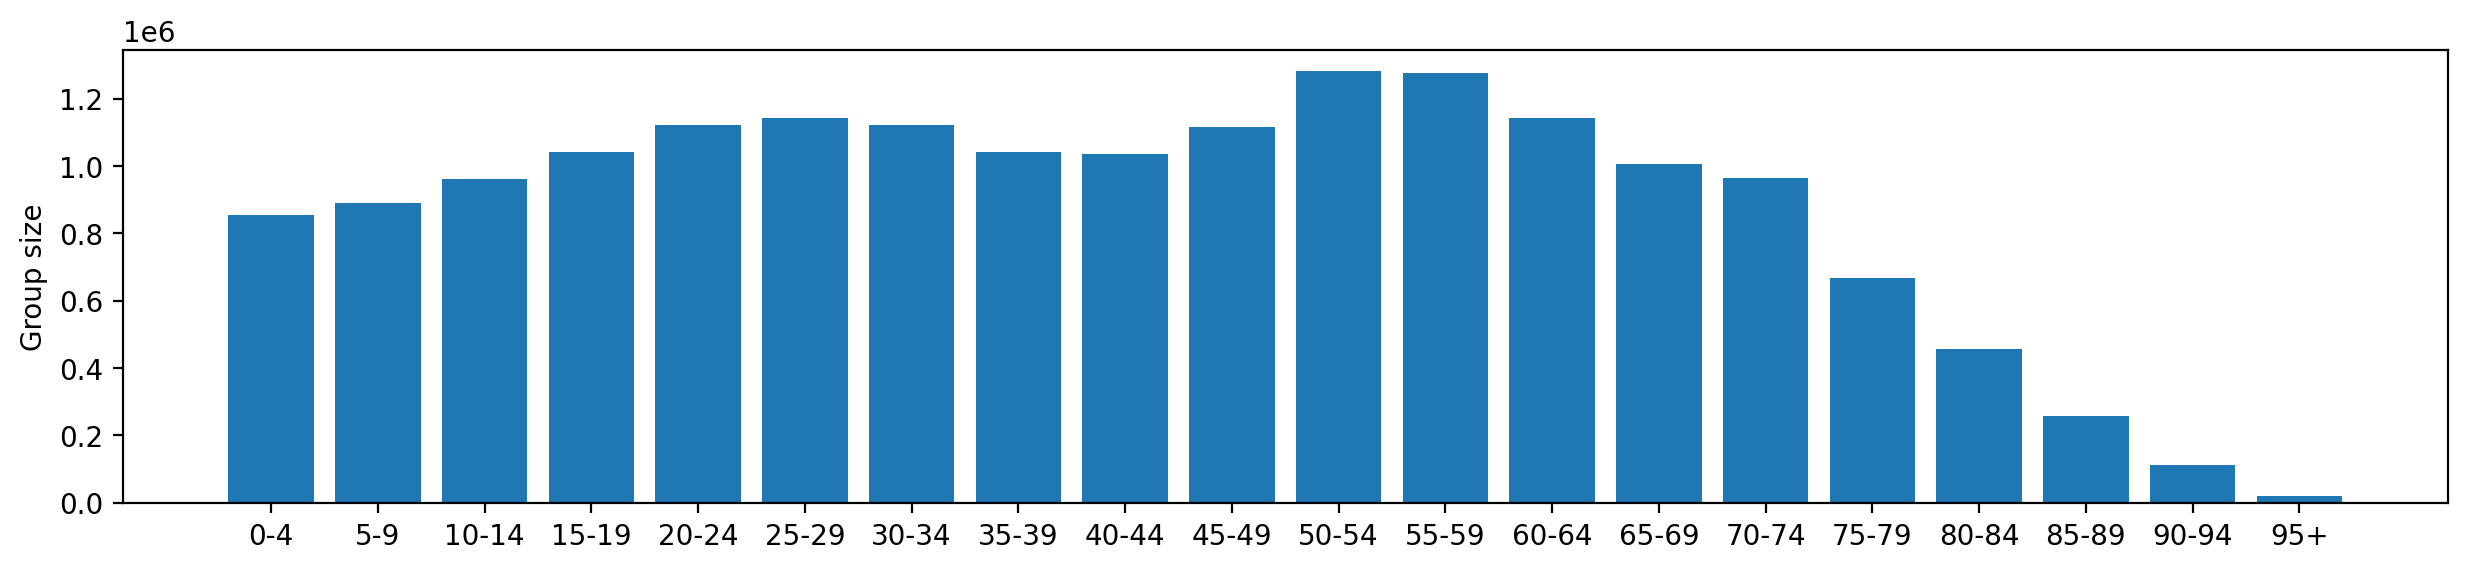

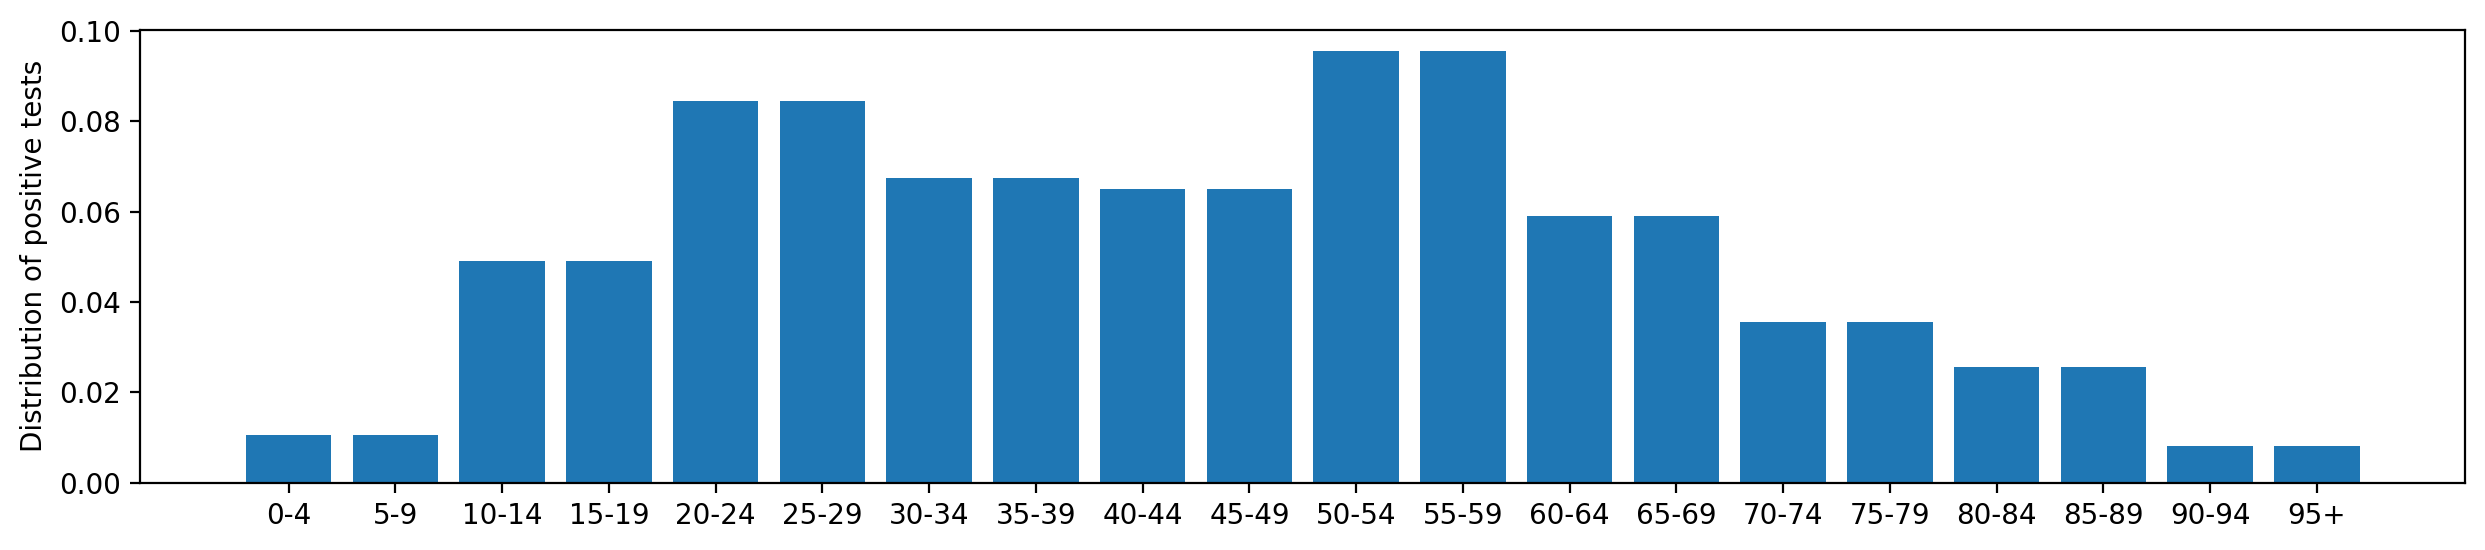

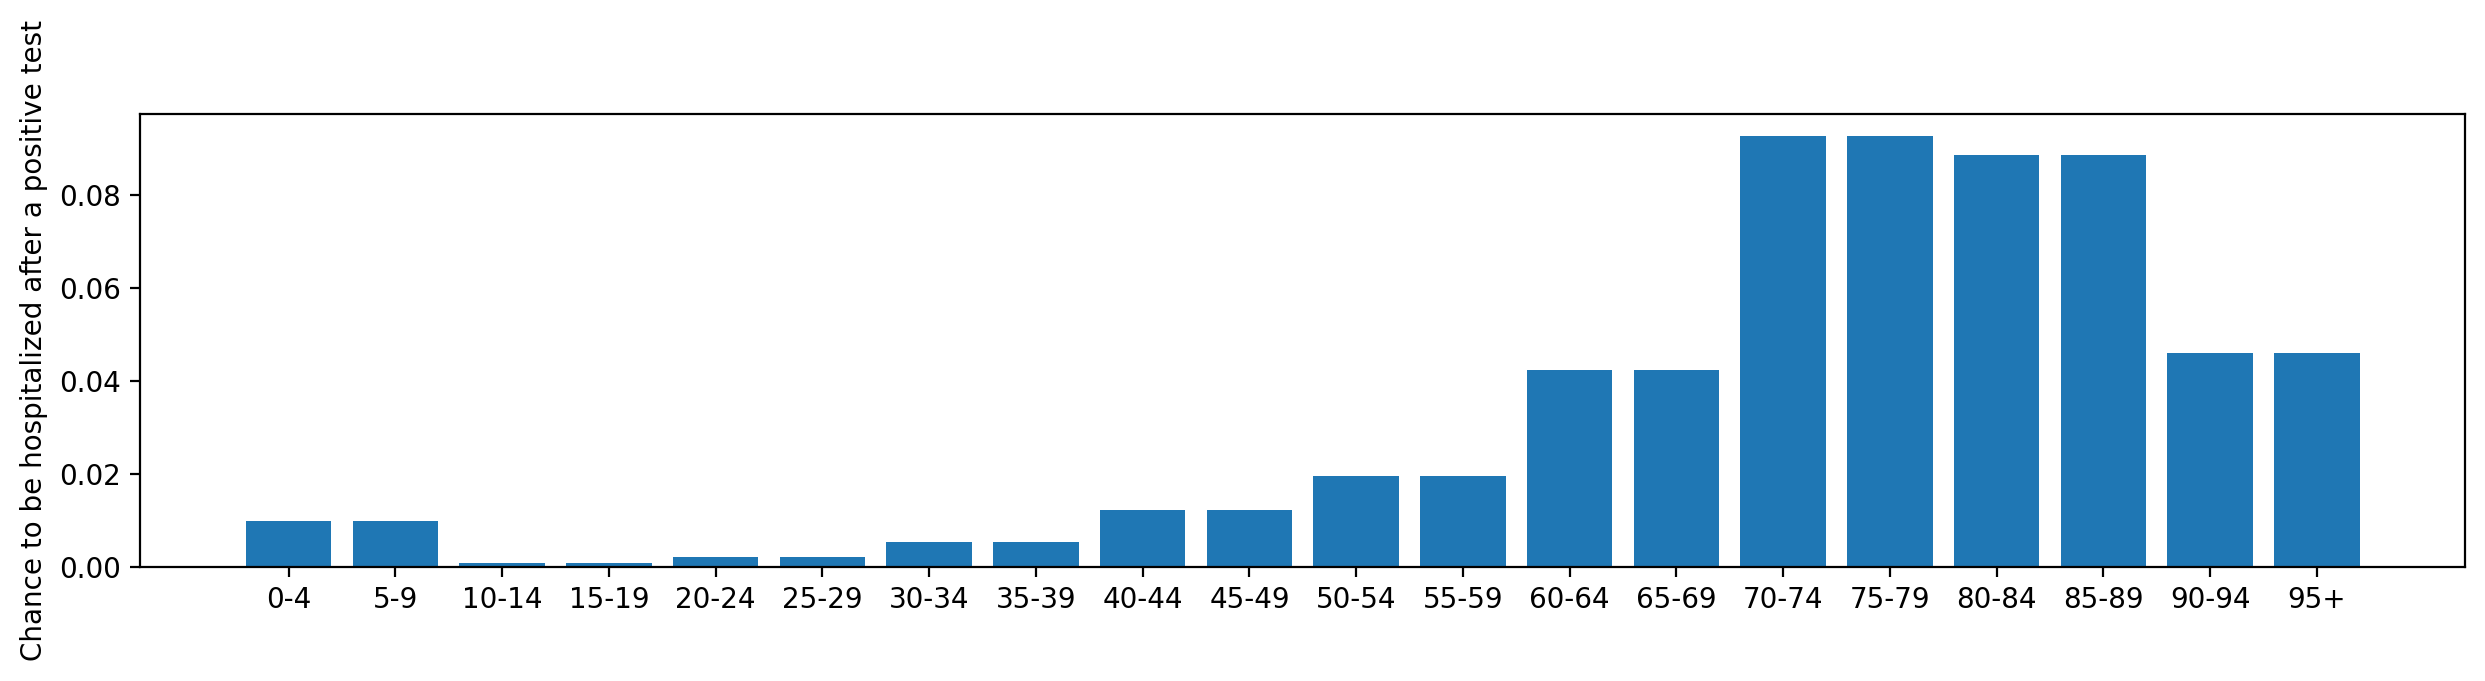

In [13]:
CitizenData = pd.read_csv('bevolkingsData.csv', delimiter = ';')

GroupSize = CitizenData.NumberOfPeople.to_list()
GroupTestedPositive_percentage = CitizenData.TestedPositive_percentage.to_list()
GroupImmune = [CountyData.Total_reported.sum() * GroupTestedPositive_percentage[idx] / 100 for idx in range(len(GroupSize))]
GroupICed = CitizenData.ICed.to_list()
GroupICedPerPositive = [GroupICed[idx] / GroupImmune[idx] for idx in range(len(GroupSize))]

GroupHospitalized = [0]*len(GroupSize)
GroupDeceased = [0]*len(GroupSize)

DataGroupNames = ['0-9','10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
for idx in range(len(DataGroupNames)):
    DataGroupData = AllCaseData.loc[DataGroupNames[idx] == AllCaseData.Agegroup]
    DataGroupDataHospitalized = DataGroupData.loc[DataGroupData.Hospital_admission == 'Yes']
    GroupHospitalized[idx*2] = len(DataGroupDataHospitalized) / 2
    GroupHospitalized[idx*2 + 1] = len(DataGroupDataHospitalized) / 2

InfectionDistribution = [a / sum(GroupImmune) for a in GroupImmune]
InfectionToHospitalization = [GroupHospitalized[idx] / GroupImmune[idx] for idx in range(len(GroupImmune))]
HospitalizationPerInfection = sum([InfectionDistribution[idx] * InfectionToHospitalization[idx] for idx in range(len(GroupImmune))])
ICPerInfection = sum([InfectionDistribution[idx] * GroupICedPerPositive[idx] for idx in range(len(GroupImmune))])

DataGroupNames = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', 
                  '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95+']

plt.figure(figsize=(15,3), dpi= 200)
plt.bar(DataGroupNames, GroupSize)
plt.ylabel('Age group')
plt.ylabel('Group size')

plt.figure(figsize=(15,3), dpi= 200)
plt.bar(DataGroupNames, InfectionDistribution)
plt.ylabel('Age group')
plt.ylabel('Distribution of positive tests')

plt.figure(figsize=(15,3), dpi= 200)
plt.bar(DataGroupNames, InfectionToHospitalization)
plt.ylabel('Age group')
plt.ylabel('Chance to be hospitalized after a positive test')


Just to verify, we look at the period from september 2020 to see how well we can predict the hospitalizations based on the number of cases

,


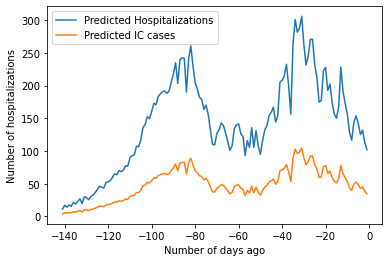

In [14]:
SelectionIdxStart = dates.index('2020-09-01') 
SelectedDates = dates[SelectionIdxStart:]  
SelectedReported = Total_reported[SelectionIdxStart:]

PredictedHospitalized = [a * HospitalizationPerInfection for a in SelectedReported]
PredictedICed = [a * ICPerInfection for a in SelectedReported]

NumberOfDaysAgo = range(-len(PredictedHospitalized), 0)

# assume instanteneous transmission and hospitalization
plt.plot(NumberOfDaysAgo, PredictedHospitalized)
# plt.plot(SelectedDates, SelectedHospitalized)
plt.plot(NumberOfDaysAgo, PredictedICed)
plt.xlabel('Number of days ago')
plt.ylabel('Number of hospitalizations')
plt.legend(('Predicted Hospitalizations', 'Predicted IC cases'))

display(HTML("<table><tr><td><img src='Nice-Hospitalizations.png'></td><td><img src='Nice-IC.png'></td></tr></table>"))

### 4.2 Implementation of the model
And now we will model the future with a more intelligent model:

In [15]:
def Model2(NumberOfDaysPredicted, GroupInfected0, GroupSusceptible0, GroupVaccinated0, CasesNonBritish0, CasesBritish0, 
           R_NonBritish):
    DaysFromNow = range(NumberOfDaysPredicted)
    GroupInfected = GroupInfected0.copy()
    GroupSusceptible = GroupSusceptible0.copy()
    GroupVaccinated = GroupVaccinated0.copy()
    CasesNonBritish = [0]*NumberOfDaysPredicted
    CasesBritish = [0]*NumberOfDaysPredicted
    CasesNonBritish[0] = CasesNonBritish0
    CasesBritish[0] = CasesBritish0
    CasesTotalPerGroup = [[0]*NumberOfDaysPredicted for idx in range(len(GroupSize))]

    Rt_NonBritish = R_NonBritish

    GroupHospitalizedPerDay = [0]*NumberOfDaysPredicted
    GroupICedPerDay = [0]*NumberOfDaysPredicted

    TotalCasesNonBritishContageous = CasesNonBritish[0]
    TotalCasesBritishContageous = CasesBritish[0]


    for day in range(NumberOfDaysPredicted-1):
        GroupCasesNonBritishInfections = [0]*len(GroupSize)
        GroupCasesBritishInfections = [0]*len(GroupSize)
        GroupCasesNonBritishSpreading = [0]*len(GroupSize)
        GroupCasesBritishSpreading = [0]*len(GroupSize)
    
        for idx in range(len(GroupSize)):   
            GroupSusceptibleForInfectionFraction = max((GroupSize[idx] - GroupInfected[idx]) * (1 - VaccineEfficacy * GroupVaccinated[idx] / GroupSize[idx]), 0) / GroupSize[idx]
            GroupCasesNonBritishInfections[idx] = InfectionDistribution[idx] * TotalCasesNonBritishContageous * (Rt_NonBritish * GroupSusceptibleForInfectionFraction) ** (1 / SerialInterval)
            GroupCasesBritishInfections[idx] = InfectionDistribution[idx] * TotalCasesBritishContageous * (Rt_NonBritish * BritishMultiplier * GroupSusceptibleForInfectionFraction) ** (1 / SerialInterval)

            GroupSusceptibleForSpreadingFraction = max((GroupSize[idx] - GroupInfected[idx]) * (1 - VaccinePreventsSpreadingFraction * VaccineEfficacy * GroupVaccinated[idx] / GroupSize[idx]), 0) / GroupSize[idx]
            GroupCasesNonBritishSpreading[idx] = InfectionDistribution[idx] * TotalCasesNonBritishContageous * (Rt_NonBritish * GroupSusceptibleForSpreadingFraction) ** (1 / SerialInterval)
            GroupCasesBritishSpreading[idx] = InfectionDistribution[idx] * TotalCasesBritishContageous * (Rt_NonBritish * BritishMultiplier * GroupSusceptibleForSpreadingFraction) ** (1 / SerialInterval)

            GroupInfected[idx] = min(GroupInfected[idx] + (GroupCasesNonBritishSpreading[idx] + GroupCasesBritishSpreading[idx]) / CaseUnderestimationFraction, GroupSize[idx])
            CasesTotalPerGroup[idx][day+1] = GroupCasesNonBritishInfections[idx] + GroupCasesBritishInfections[idx]
        # vaccineRound, old->young:
        if day >= VaccineWorkingDelay:
            VaccinesAvailable = DailyVaccinated
        else:
            VaccinesAvailable = 0
        for idx in range(len(GroupSize))[::-1]:  
            VaccinesPossibleThisGroup = GroupSize[idx] - GroupVaccinated[idx]
            VaccinesGivenThisGroup = min(VaccinesAvailable, VaccinesPossibleThisGroup)
            GroupVaccinated[idx] = GroupVaccinated[idx] + VaccinesGivenThisGroup
            VaccinesAvailable = VaccinesAvailable - VaccinesGivenThisGroup

        CasesNonBritish[day+1] = sum(GroupCasesNonBritishInfections)
        CasesBritish[day+1] = sum(GroupCasesBritishInfections)
        TotalCasesNonBritishContageous = sum(GroupCasesNonBritishSpreading)
        TotalCasesBritishContageous = sum(GroupCasesBritishSpreading)
    
    return DaysFromNow, CasesNonBritish, CasesBritish, CasesTotalPerGroup

Below we run this model:

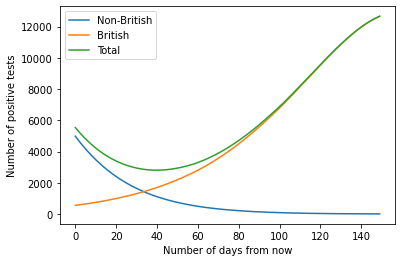

In [16]:
NumberOfDaysPredicted = 150
GroupInfected0 = [CountyData.Total_reported.sum() * GroupTestedPositive_percentage[idx] / 100 / CaseUnderestimationFraction + (CasesTotalSanquin - CountyData.Total_reported.sum() / CaseUnderestimationFraction) / len(GroupSize)  for idx in range(len(GroupSize))]
GroupSusceptible0 = [GroupSize[idx] - GroupInfected0[idx] for idx in range(len(GroupSize))]
GroupVaccinated0 = [0]*len(GroupSize)
CasesNonBritish0 = np.mean(Total_reported[len(Total_reported)-7:]) * (1 - CurrentFractionBritish)
CasesBritish0 = np.mean(Total_reported[len(Total_reported)-7:]) * CurrentFractionBritish
R_NonBritish = (ThrustFactorReproductionNumber*Rt_current_NonBritish_hospitalized + (1 - ThrustFactorReproductionNumber)*Rt_current_NonBritish_reported) / (sum(GroupSusceptible0) / sum(GroupSize))

DaysFromNow, CasesNonBritish, CasesBritish, CasesTotalPerGroup = Model2(NumberOfDaysPredicted, GroupInfected0, 
                                                                        GroupSusceptible0, GroupVaccinated0, 
                                                                        CasesNonBritish0, CasesBritish0, R_NonBritish)

CasesTotal = [CasesNonBritish[idx] + CasesBritish[idx] for idx in range(NumberOfDaysPredicted)]
  
plt.plot(DaysFromNow, CasesNonBritish)
plt.plot(DaysFromNow, CasesBritish)
plt.plot(DaysFromNow, CasesTotal)
plt.xlabel('Number of days from now')
plt.ylabel('Number of positive tests')
plt.legend(('Non-British', 'British', 'Total'))


# Save for final graph
days3 = DaysFromNow
CasesTotal3 = CasesTotal.copy()
PercentageBritish3 = [100 * b / (a + b) for a, b in zip(CasesNonBritish, CasesBritish)]

Calculate the number of hospitalizations that the model predicts

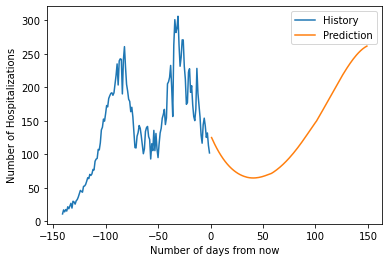

In [17]:
HospitalizationsTotalPerGroup = [[InfectionToHospitalization[groupIdx] * CasesTotalPerGroup[groupIdx][dayIdx] for dayIdx in range(NumberOfDaysPredicted)] for groupIdx in range(len(GroupSize))]
HospitalizationsTotal = [sum([HospitalizationsTotalPerGroup[groupIdx][dayIdx] for groupIdx in range(len(GroupSize))]) for dayIdx in range(NumberOfDaysPredicted)]

plt.plot(NumberOfDaysAgo, PredictedHospitalized)
plt.plot(DaysFromNow[1:], HospitalizationsTotal[1:])

plt.xlabel('Number of days from now')
plt.ylabel('Number of Hospitalizations')
plt.legend(('History', 'Prediction'))

HospitalizationsTotal3 = HospitalizationsTotal.copy()

## 5. A slightly more optimistic scenario
Suppose the vaccine prevents 50% of all infections that a vaccinated person would normallt cause, this is what would happen:

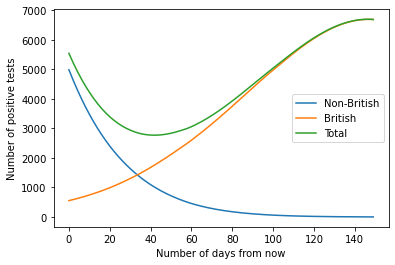

In [18]:
VaccinePreventsSpreadingFraction = 0.5      # 0: does not prevent, 1: prevents all

DaysFromNow, CasesNonBritish, CasesBritish, CasesTotalPerGroup = Model2(NumberOfDaysPredicted, GroupInfected0, 
                                                                        GroupSusceptible0, GroupVaccinated0, 
                                                                        CasesNonBritish0, CasesBritish0, R_NonBritish)

CasesTotal = [CasesNonBritish[idx] + CasesBritish[idx] for idx in range(NumberOfDaysPredicted)]
  
days4 = DaysFromNow
CasesTotal4 = CasesTotal.copy()
PercentageBritish4 = [100 * b / (a + b) for a, b in zip(CasesNonBritish, CasesBritish)]

plt.plot(DaysFromNow, CasesNonBritish)
plt.plot(DaysFromNow, CasesBritish)
plt.plot(DaysFromNow, CasesTotal)
plt.xlabel('Number of days from now')
plt.ylabel('Number of positive tests')
plt.legend(('Non-British', 'British', 'Total'))

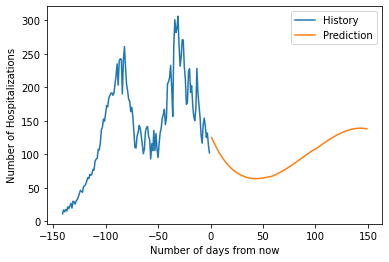

In [19]:
HospitalizationsTotalPerGroup = [[InfectionToHospitalization[groupIdx] * CasesTotalPerGroup[groupIdx][dayIdx] for dayIdx in range(NumberOfDaysPredicted)] for groupIdx in range(len(GroupSize))]
HospitalizationsTotal = [sum([HospitalizationsTotalPerGroup[groupIdx][dayIdx] for groupIdx in range(len(GroupSize))]) for dayIdx in range(NumberOfDaysPredicted)]

plt.plot(NumberOfDaysAgo, PredictedHospitalized)
plt.plot(DaysFromNow[1:], HospitalizationsTotal[1:])

plt.xlabel('Number of days from now')
plt.ylabel('Number of Hospitalizations')
plt.legend(('History', 'Prediction'))

HospitalizationsTotal4 = HospitalizationsTotal.copy()

## Optimistic scenario

Suppose the vaccine prevents 100% of all infections that a vaccinated person would normallt cause, this is what would happen:


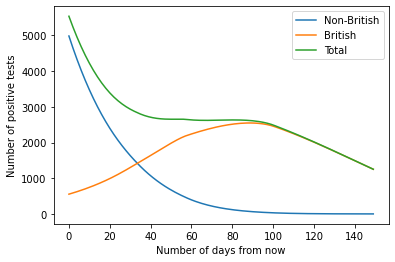

In [20]:
VaccinePreventsSpreadingFraction = 1      # 0: does not prevent, 1: prevents all

DaysFromNow, CasesNonBritish, CasesBritish, CasesTotalPerGroup = Model2(NumberOfDaysPredicted, GroupInfected0, 
                                                                        GroupSusceptible0, GroupVaccinated0, 
                                                                        CasesNonBritish0, CasesBritish0, R_NonBritish)

CasesTotal = [CasesNonBritish[idx] + CasesBritish[idx] for idx in range(NumberOfDaysPredicted)]
  
days5 = DaysFromNow
CasesTotal5 = CasesTotal.copy()
PercentageBritish5 = [100 * b / (a + b) for a, b in zip(CasesNonBritish, CasesBritish)]

plt.plot(DaysFromNow, CasesNonBritish)
plt.plot(DaysFromNow, CasesBritish)
plt.plot(DaysFromNow, CasesTotal)
plt.xlabel('Number of days from now')
plt.ylabel('Number of positive tests')
plt.legend(('Non-British', 'British', 'Total'))

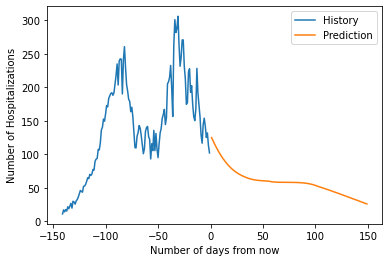

In [21]:
HospitalizationsTotalPerGroup = [[InfectionToHospitalization[groupIdx] * CasesTotalPerGroup[groupIdx][dayIdx] for dayIdx in range(NumberOfDaysPredicted)] for groupIdx in range(len(GroupSize))]
HospitalizationsTotal = [sum([HospitalizationsTotalPerGroup[groupIdx][dayIdx] for groupIdx in range(len(GroupSize))]) for dayIdx in range(NumberOfDaysPredicted)]

plt.plot(NumberOfDaysAgo, PredictedHospitalized)
plt.plot(DaysFromNow[1:], HospitalizationsTotal[1:])

plt.xlabel('Number of days from now')
plt.ylabel('Number of Hospitalizations')
plt.legend(('History', 'Prediction'))

HospitalizationsTotal5 = HospitalizationsTotal.copy()

# Combine the graphs

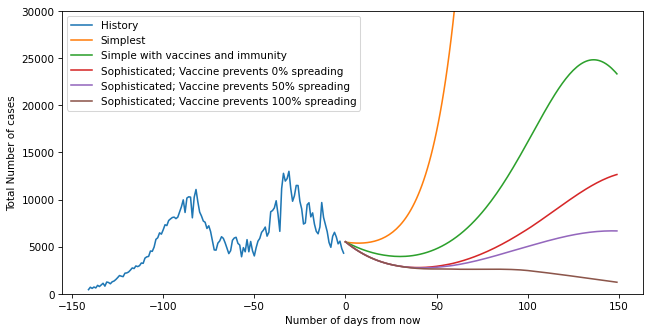

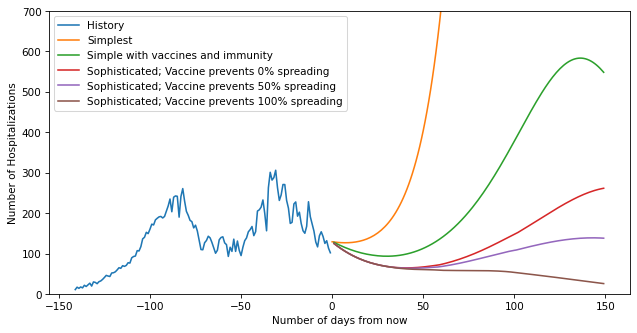

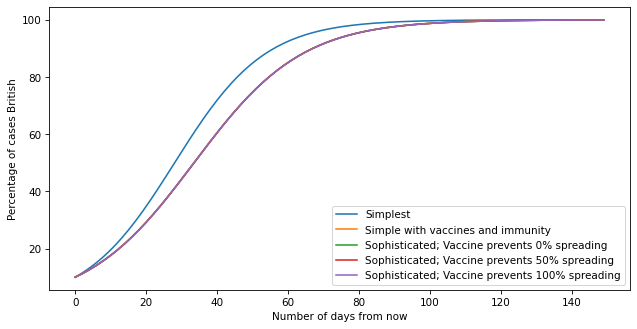

In [22]:
plt.figure(figsize=(10,5), dpi= 75)
plt.plot(NumberOfDaysAgo, SelectedReported)
plt.plot(days1, [case for case in CasesTotal1])
plt.plot(days2, CasesTotal2)
plt.plot(days3, CasesTotal3)
plt.plot(days4, CasesTotal4)
plt.plot(days4, CasesTotal5)

plt.xlabel('Number of days from now')
plt.ylabel('Total Number of cases')
plt.ylim(0, 30000)
plt.legend(('History', 'Simplest', 'Simple with vaccines and immunity', 'Sophisticated; Vaccine prevents 0% spreading', 'Sophisticated; Vaccine prevents 50% spreading', 'Sophisticated; Vaccine prevents 100% spreading'))

plt.figure(figsize=(10,5), dpi= 75)
plt.plot(NumberOfDaysAgo, PredictedHospitalized)
plt.plot(days1, [case * HospitalizationsPerInfection for case in CasesTotal1])
[a + b for a, b in zip(Cases_not_British, Cases_British)]
plt.plot(days2[1:], HospitalizationsTotal2[1:])
plt.plot(days3[1:], HospitalizationsTotal3[1:])
plt.plot(days4[1:], HospitalizationsTotal4[1:])
plt.plot(days4[1:], HospitalizationsTotal5[1:])

plt.ylim(0, 700)
plt.xlabel('Number of days from now')
plt.ylabel('Number of Hospitalizations')
plt.legend(('History', 'Simplest', 'Simple with vaccines and immunity', 'Sophisticated; Vaccine prevents 0% spreading', 'Sophisticated; Vaccine prevents 50% spreading', 'Sophisticated; Vaccine prevents 100% spreading'))


plt.figure(figsize=(10,5), dpi= 75)
plt.plot(days1, PercentageBritish1)
plt.plot(days2, PercentageBritish2)
plt.plot(days3, PercentageBritish3)
plt.plot(days4, PercentageBritish4)
plt.plot(days5, PercentageBritish5)
plt.xlabel('Number of days from now')
plt.ylabel('Percentage of cases British')
plt.legend(('Simplest', 'Simple with vaccines and immunity', 'Sophisticated; Vaccine prevents 0% spreading', 'Sophisticated; Vaccine prevents 50% spreading', 'Sophisticated; Vaccine prevents 100% spreading'))



Ideas to continue:
- Estimate Covid patients in hospital and IC based on length of stay
- Include uncertainty
- Analyse parameter sensitivity
- Analyse worst case scenario with more strict measures later on (when do measures have to be taken?)
- Analyse possible opening of schools
- Guestimate of weather influence